In [1]:
# imports

import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

## Functions

In [49]:
# read a folder of images and turn them into an array

def read_images_to_array(folder_path):

  image_array = []
  # Get a sorted list of filenames
  filenames = sorted(os.listdir(folder_path))
  for filename in filenames:
    if filename.endswith(".jpg") or filename.endswith(".png"):
      img_path = os.path.join(folder_path, filename)
      img = cv2.imread(img_path)

      if img is not None:
        image_array.append(img)

  return image_array

def split_images(image_array): 

    red_region_images = []
    raw_images = [] 

    for image in image_array:
        if image[25,100].sum() == 255*3 :
            red_region_images.append(image)
        else: 
            raw_images.append(image) 
            
    return red_region_images, raw_images

def crop_raw_images(image_array): 
    
    cropped_images = [] 
    
    for i in range(len(image_array)): 
        
        image = image_array[i]
        
        mask = np.zeros(image.shape, dtype=np.uint8)
        mask = cv2.circle(mask, (320, 240), 200, (255,255,255), -1)

        res = cv2.bitwise_and(image, mask)
        res[mask==0] = 255
        
        cropped_images.append(res)

    return cropped_images

def crop_masks(image_array):
    cropped_masks = []

    for image in image_array:
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        mask = cv2.circle(mask, (250, 257), 135, (255, 255, 255), -1)

        if image.shape[:2] != mask.shape:
            raise ValueError("Image and mask dimensions do not match.")

        res = cv2.bitwise_and(image, image, mask=mask)
        res[mask == 0] = 255

        cropped_masks.append(res)

    return cropped_masks

def create_binary_masks(image_array):
    binary_masks = []
    
    for image in image_array:
        # Ensure image is in BGR format (convert if necessary)
        if image.ndim == 2:
            # Convert grayscale to BGR color (assuming gray image)
            image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        elif image.shape[2] != 3:
            raise ValueError("Input image must have 3 channels (BGR format).")
        else:
            image_color = image
        
        # Convert BGR to HSV
        hsv = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)

        # Define lower and upper bounds for red color in HSV
        lower_red = np.array([0, 150, 115])
        upper_red = np.array([255, 255, 255])

        # Create mask using inRange function
        mask = cv2.inRange(hsv, lower_red, upper_red)

        # Apply bitwise AND operation using color image
        res = cv2.bitwise_and(image_color, image_color, mask=mask)
        
        binary_masks.append(mask)
        
    return binary_masks

def create_blank_masks(image_array): 
    masks = []
    for i in range(len(image_array) - 1): 
        mask = np.zeros((256, 256), dtype=np.uint8)  # Create a 2D array filled with zeros
        masks.append(mask)
    return masks

def zoom_at(image_array, zoom, coord=None):
    
    zoomed_array = []
    
    for img in image_array: 
        

        # Translate to zoomed coordinates
        h, w, _ = [ zoom * i for i in img.shape ]

        if coord is None: cx, cy = w/2, h/2
        else: cx, cy = [ zoom*c for c in coord ]

        img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
        img = img[ int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
                   int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5)),
                   : ]
        zoomed_array.append(img)
    
    return zoomed_array

def double_crop(image_array): 
    
    cropped_images = []
    
    for image in image_array: 
        
        # this is crop for each side (totalCrop/2) 
        cropped_image = image[0:515, 70:570]
        
        cropped_images.append(cropped_image)
    
    return cropped_images

def add_padding(image_array): 
    
    padded_images = []
    
    for image in image_array: 

        padded_image = cv2.copyMakeBorder(
            image,
            17,
            17,
            0,
            0,
            cv2.BORDER_CONSTANT,
            value=(255,255,255)
        )
        
        padded_images.append(padded_image)
        
    return padded_images


In [64]:
# get bounding box 

def get_bounding_box(image_mask):

    if len(image_mask.shape) == 2:
        gray = image_mask
    else:
        gray = cv2.cvtColor(image_mask, cv2.COLOR_BGR2GRAY)
    
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    
    if len(contours) == 0:
        return None 

    x, y, w, h = cv2.boundingRect(contours[0])
    
    bbox = [x, y, w, h]
    
    return bbox

## Apply Functions

In [58]:
# get images
folder_path_training = './data/training_images'
train_images = read_images_to_array(folder_path_training)
folder_path_val = './data/val_images'
val_images = read_images_to_array(folder_path_val)

# split them 
train_masks, train_raw = split_images(train_images)
val_masks, val_raw = split_images(val_images) 

# crop each one out 
train_raw = crop_raw_images(train_raw) 
val_raw = crop_raw_images(val_raw) 
train_masks = crop_masks(train_masks)
val_masks = crop_masks(val_masks) 

# zoom masks
train_masks = zoom_at(train_masks, 1.4, coord=None)
val_masks = zoom_at(val_masks, 1.4, coord=None)

# create binary masks]
train_masks = create_binary_masks(train_masks)
val_masks = create_binary_masks(val_masks) 

# crop raw images 
train_raw = double_crop(train_raw)
val_raw = double_crop(val_raw) 

#add padding to raw images 
train_raw = add_padding(train_raw) 
val_raw = add_padding(val_raw) 

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'boundingRect'
> Overload resolution failed:
>  - array is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'array'


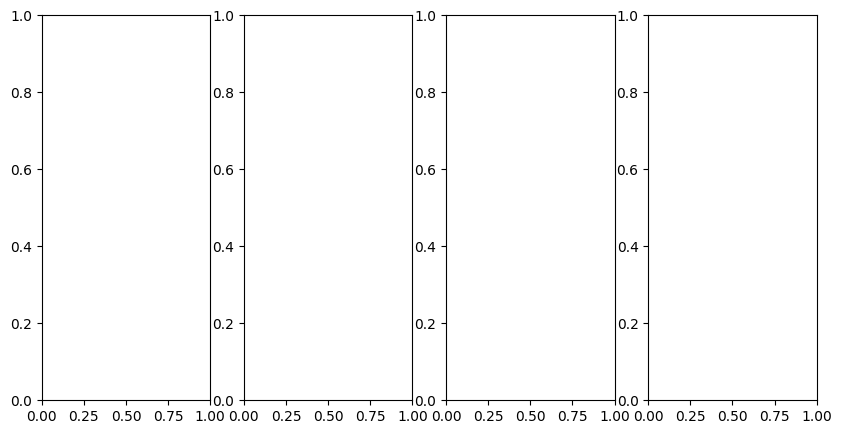

In [77]:
# picks a random image and displays it

rand_train = random.randint(0, len(train_raw) - 1) 
rand_val = random.randint(0, len(val_raw) - 1) 

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

bbox = get_bounding_box(train_masks[rand_train])

cv2.rectangle(train_raw[rand_train], (bbox[0], bbox[1]), (bbox[2], bbox[3]), 0, 5)

ax[0].imshow(train_masks[rand_train], cmap = "gray")
ax[0].set_title('Binary Mask (training)')

ax[1].imshow(train_raw[rand_train])
ax[1].set_title('Raw Image (training)')

ax[2].imshow(val_masks[rand_val], cmap ="gray") 
ax[2].set_title("Binary Mask (validation)") 

ax[3].imshow(val_raw[rand_val]) 
ax[3].set_title("Raw Image (validation)")

In [48]:
train_masks = np.array(train_masks)
train_raw = np.array(train_raw) 

print(train_masks.shape)
print(train_raw.shape)

(154, 515, 500)
(154, 514, 500, 3)
